# SDXL Image Enhancement for Landscape Images (No Text)

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fd9_1c2j
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fd9_1c2j
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=72b9a5de41f5e3a080a1caa619e8dc1053c22f0f07638eea490d29bf1923ea9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lyorsqr/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


## Import Libraries

In [3]:
import os
from PIL import Image
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
import io
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim
import torchvision.transforms.functional as TF
import clip
from torch.nn import CosineSimilarity

## Set Up File Paths

In [4]:
# Mounting to Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Paths to original images (without text)
no_text_dir = '/content/drive/MyDrive/images_no_text'

# Function to upload the images
def images_upload(folder):
    images, filenames = [], sorted(os.listdir(folder))
    for filename in filenames:
        image_path = os.path.join(folder, filename)
        image = Image.open(image_path).convert('RGB')
        images.append(image)
    return images, filenames

images_no_text, filenames_no_text = images_upload(no_text_dir)

print(f"Downloaded {len(images_no_text)} images without text.")

Mounted at /content/drive
Downloaded 10 images without text.


In [5]:
# Output directory
output_dir = '/content/drive/MyDrive/sdxl_output_no_text'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Verify that the directory exists
if not os.path.exists(no_text_dir):
    print(f"Warning: Directory {no_text_dir} does not exist!")
else:
    print(f"Found directory: {no_text_dir}")
    files = os.listdir(no_text_dir)
    print(f"  Contains {len(files)} files")
    if files:
        print(f"  Sample files: {', '.join(files[:3])}{'...' if len(files) > 3 else ''}")

Found directory: /content/drive/MyDrive/images_no_text
  Contains 10 files
  Sample files: a.jpg, b.jpg, c.jpg...


## Initialize SDXL

In [6]:
# Check GPU availability and set device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected, using CPU.")

# Initialize SDXL model (Image-to-Image)
torch_dtype = torch.float16 if device == "cuda" else torch.float32

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    torch_dtype=torch_dtype,
    use_safetensors=True
).to(device)

Using GPU: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/9.04G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## Initialize CLIP Model for Evaluation

In [7]:
# Initialize CLIP Model for Evaluation
def init_clip():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess, device


# Use this function instead of directly loading CLIP in the notebook
clip_model, clip_preprocess, device = init_clip()
print("CLIP model loaded successfully!")

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 115MiB/s]


CLIP model loaded successfully!


## Define Utility Functions

In [8]:
# Function to load images
def images_upload(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder, filename)
            try:
                image = Image.open(image_path).convert('RGB')
                images.append(image)
                filenames.append(filename)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images, filenames

# Function to resize images by half
def resize(images, scale_factor=0.5):
    resized_images = []
    for img in images:
        width, height = img.size
        new_size = (int(width * scale_factor), int(height * scale_factor))
        resized_image = img.resize(new_size, Image.Resampling.LANCZOS)
        resized_images.append(resized_image)
    return resized_images

# Function to calculate CLIP similarity score
def calculate_clip_similarity(image1, image2):
    # Preprocess images for CLIP
    image1_preprocessed = clip_preprocess(image1).unsqueeze(0).to(device)
    image2_preprocessed = clip_preprocess(image2).unsqueeze(0).to(device)

    # Get image features
    with torch.no_grad():
        image1_features = clip_model.encode_image(image1_preprocessed)
        image2_features = clip_model.encode_image(image2_preprocessed)

    # Normalize features
    image1_features = image1_features / image1_features.norm(dim=-1, keepdim=True)
    image2_features = image2_features / image2_features.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity
    similarity = torch.nn.functional.cosine_similarity(image1_features, image2_features).item()

    return similarity

# Function to calculate prompt-image CLIP similarity
def calculate_prompt_image_similarity(prompt, image):
    # Preprocess image for CLIP
    image_preprocessed = clip_preprocess(image).unsqueeze(0).to(device)

    # Tokenize text
    text = clip.tokenize([prompt]).to(device)

    # Get features
    with torch.no_grad():
        image_features = clip_model.encode_image(image_preprocessed)
        text_features = clip_model.encode_text(text)

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity
    similarity = torch.nn.functional.cosine_similarity(image_features, text_features).item()

    return similarity

## Predefined Prompts for Landscape Images

In [9]:
# Individual prompts for each image
prompts_no_text = [
    "vast green wheat field under a clear deep blue sky, scattered trees on the horizon, contrails from airplanes, bright sunny day, photorealistic, ultra wide landscape, peaceful atmosphere",
    "aerial view of a winding river at sunset, surrounded by dark mountain silhouettes, dramatic sky with clouds glowing orange and blue, tranquil and vast scenery, cinematic lighting",
    "serene alpine lake reflecting snow-covered mountains, calm water surface, early morning blue light, majestic peaks in the background, cold and crisp atmosphere, photorealistic",
    "turquoise mountain lake winding through pine forests, surrounded by green slopes and snow-capped peaks, clouds over the mountains, vibrant and photorealistic landscape",
    "autumn forest with colorful trees reflected in a mountain lake, towering rocky mountains in the background, bright sky with turquoise tint, photorealistic alpine landscape",
    "lush green meadow with scattered rocks and trees, steep forested mountains in the distance, sunny day with soft clouds, wild landscape, nature photography aesthetic",
    "beautiful botanical garden with blooming pink azaleas, calm pond with wooden footbridge, lush greenery, bright clear blue sky, well-maintained landscape, HDR style",
    "dramatic coastal cliffs over turquoise blue ocean bay, soft evening light, rolling green hills above the cliffs, aerial view, scenic and vast seascape, warm tones",
    "still mountain lake reflecting distant alpine peaks, conifer trees along the waterline, wide valley with clear sky and clouds, crisp mountain air, natural lighting",
    "stormy mountain landscape with dark clouds and spotlight sunbeam illuminating a green valley, dramatic contrast between light and shadow, snow-covered peaks under cloud cover, cinematic mood"
]

## SDXL Image Generation

In [10]:
# Generate SDXL images with predefined prompts
def generate_sdxl(images, prompts, filenames, strength=0.5, guidance_scale=3, save_dir=None):
    sdxl_images = []

    # Ensure we have enough prompts
    if len(prompts) < len(images):
        # Repeat the prompts if needed
        prompts = prompts * (len(images) // len(prompts) + 1)
        prompts = prompts[:len(images)]

    for i, (img, prompt, filename) in enumerate(zip(images, prompts, filenames)):
        print(f"Processing image {i+1}/{len(images)}: {filename}")
        print(f"Prompt: {prompt}")
        # Count approximate tokens
        word_count = len(prompt.split())
        print(f"Word count: {word_count}")

        img = img.convert("RGB")
        try:
            result = pipe(
                prompt=prompt,
                image=img,
                strength=strength,
                guidance_scale=guidance_scale,
            ).images[0]

            sdxl_images.append(result)

            # Save the result immediately if a save directory is provided
            if save_dir:
                base_name = os.path.splitext(filename)[0]
                result.save(os.path.join(save_dir, f'enhanced_{base_name}.png'))
                print(f"Saved as: enhanced_{base_name}.png")

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            # Append the original image as a fallback
            sdxl_images.append(img)

        print("---")

    return sdxl_images

## Process Images

In [11]:
# Load landscape images
print("Loading landscape images...")
images_no_text, filenames_no_text = images_upload(no_text_dir)

if len(images_no_text) > 0:
    print(f"Loaded {len(images_no_text)} landscape images")

    # Resize images
    print("Resizing landscape images...")
    resized_no_text = resize(images_no_text)

    # Generate enhanced images
    print("\nGenerating SDXL enhanced images...")
    sdxl_no_text = generate_sdxl(resized_no_text, prompts_no_text, filenames_no_text,
                               strength=0.5, guidance_scale=3, save_dir=output_dir)
else:
    print("No images found in the landscape directory!")

Loading landscape images...
Loaded 10 landscape images
Resizing landscape images...

Generating SDXL enhanced images...
Processing image 1/10: a.jpg
Prompt: vast green wheat field under a clear deep blue sky, scattered trees on the horizon, contrails from airplanes, bright sunny day, photorealistic, ultra wide landscape, peaceful atmosphere
Word count: 27


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_a.png
---
Processing image 2/10: b.jpg
Prompt: aerial view of a winding river at sunset, surrounded by dark mountain silhouettes, dramatic sky with clouds glowing orange and blue, tranquil and vast scenery, cinematic lighting
Word count: 27


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_b.png
---
Processing image 3/10: c.jpg
Prompt: serene alpine lake reflecting snow-covered mountains, calm water surface, early morning blue light, majestic peaks in the background, cold and crisp atmosphere, photorealistic
Word count: 23


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_c.png
---
Processing image 4/10: e.jpg
Prompt: turquoise mountain lake winding through pine forests, surrounded by green slopes and snow-capped peaks, clouds over the mountains, vibrant and photorealistic landscape
Word count: 22


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_e.png
---
Processing image 5/10: f.jpg
Prompt: autumn forest with colorful trees reflected in a mountain lake, towering rocky mountains in the background, bright sky with turquoise tint, photorealistic alpine landscape
Word count: 24


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_f.png
---
Processing image 6/10: g.jpg
Prompt: lush green meadow with scattered rocks and trees, steep forested mountains in the distance, sunny day with soft clouds, wild landscape, nature photography aesthetic
Word count: 24


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_g.png
---
Processing image 7/10: h.jpg
Prompt: beautiful botanical garden with blooming pink azaleas, calm pond with wooden footbridge, lush greenery, bright clear blue sky, well-maintained landscape, HDR style
Word count: 22


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_h.png
---
Processing image 8/10: i.jpg
Prompt: dramatic coastal cliffs over turquoise blue ocean bay, soft evening light, rolling green hills above the cliffs, aerial view, scenic and vast seascape, warm tones
Word count: 25


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_i.png
---
Processing image 9/10: j.jpg
Prompt: still mountain lake reflecting distant alpine peaks, conifer trees along the waterline, wide valley with clear sky and clouds, crisp mountain air, natural lighting
Word count: 24


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_j.png
---
Processing image 10/10: d.jpg
Prompt: stormy mountain landscape with dark clouds and spotlight sunbeam illuminating a green valley, dramatic contrast between light and shadow, snow-covered peaks under cloud cover, cinematic mood
Word count: 26


  0%|          | 0/25 [00:00<?, ?it/s]

Saved as: enhanced_d.png
---


## Evaluate Results with Multiple Metrics

In [12]:
# Function to calculate all metrics for image comparison
def calculate_metrics(original_imgs, generated_imgs, prompts):
    metrics = []

    for i, (orig, gen, prompt) in enumerate(zip(original_imgs, generated_imgs, prompts)):
        # Resize original to match generated if needed
        if orig.size != gen.size:
            orig = orig.resize(gen.size, Image.Resampling.LANCZOS)

        # Convert to tensors for PSNR and SSIM
        orig_tensor = TF.to_tensor(orig).unsqueeze(0)
        gen_tensor = TF.to_tensor(gen).unsqueeze(0)

        # Calculate PSNR and SSIM
        psnr_value = psnr(gen_tensor, orig_tensor).item()
        ssim_value = ssim(gen_tensor, orig_tensor).item()

        # Calculate CLIP similarity between original and generated
        clip_sim = calculate_clip_similarity(orig, gen)

        # Calculate CLIP similarity between prompt and generated image
        prompt_img_sim = calculate_prompt_image_similarity(prompt, gen)

        metrics.append({
            'psnr': psnr_value,
            'ssim': ssim_value,
            'clip_img_similarity': clip_sim,
            'prompt_img_similarity': prompt_img_sim
        })

    return metrics

In [13]:
# Calculate metrics for landscape images
if 'sdxl_no_text' in locals() and len(sdxl_no_text) > 0:
    metrics_no_text = calculate_metrics(
        resized_no_text,
        sdxl_no_text,
        prompts_no_text[:len(sdxl_no_text)]
    )

    # Print average metrics
    avg_psnr = sum(m['psnr'] for m in metrics_no_text) / len(metrics_no_text)
    avg_ssim = sum(m['ssim'] for m in metrics_no_text) / len(metrics_no_text)
    avg_clip_sim = sum(m['clip_img_similarity'] for m in metrics_no_text) / len(metrics_no_text)
    avg_prompt_sim = sum(m['prompt_img_similarity'] for m in metrics_no_text) / len(metrics_no_text)

    print(f"Average PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.3f}")
    print(f"Average CLIP Image Similarity: {avg_clip_sim:.3f}")
    print(f"Average Prompt-Image Similarity: {avg_prompt_sim:.3f}")

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Average PSNR: 21.05
Average SSIM: 0.570
Average CLIP Image Similarity: 0.881
Average Prompt-Image Similarity: 0.283


## Visualize Results

In [14]:
# Function for visualizing results with all metrics
def visualize_results(original_images, enhanced_images, filenames, metrics, prompts, num_images=None):
    if num_images is None:
        num_images = len(original_images)
    else:
        num_images = min(num_images, len(original_images))

    plt.figure(figsize=(20, 6 * num_images))

    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_images[i])
        plt.title(f'Original: {filenames[i]}')
        plt.axis('off')

        # Enhanced image with metrics
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(enhanced_images[i])
        metrics_str = (f"PSNR: {metrics[i]['psnr']:.2f}, SSIM: {metrics[i]['ssim']:.3f}\n"
                      f"CLIP Img Sim: {metrics[i]['clip_img_similarity']:.3f}, "
                      f"Prompt-Img Sim: {metrics[i]['prompt_img_similarity']:.3f}")
        plt.title(f"Enhanced {filenames[i]}\n{metrics_str}\nPrompt: {prompts[i][:50]}...")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

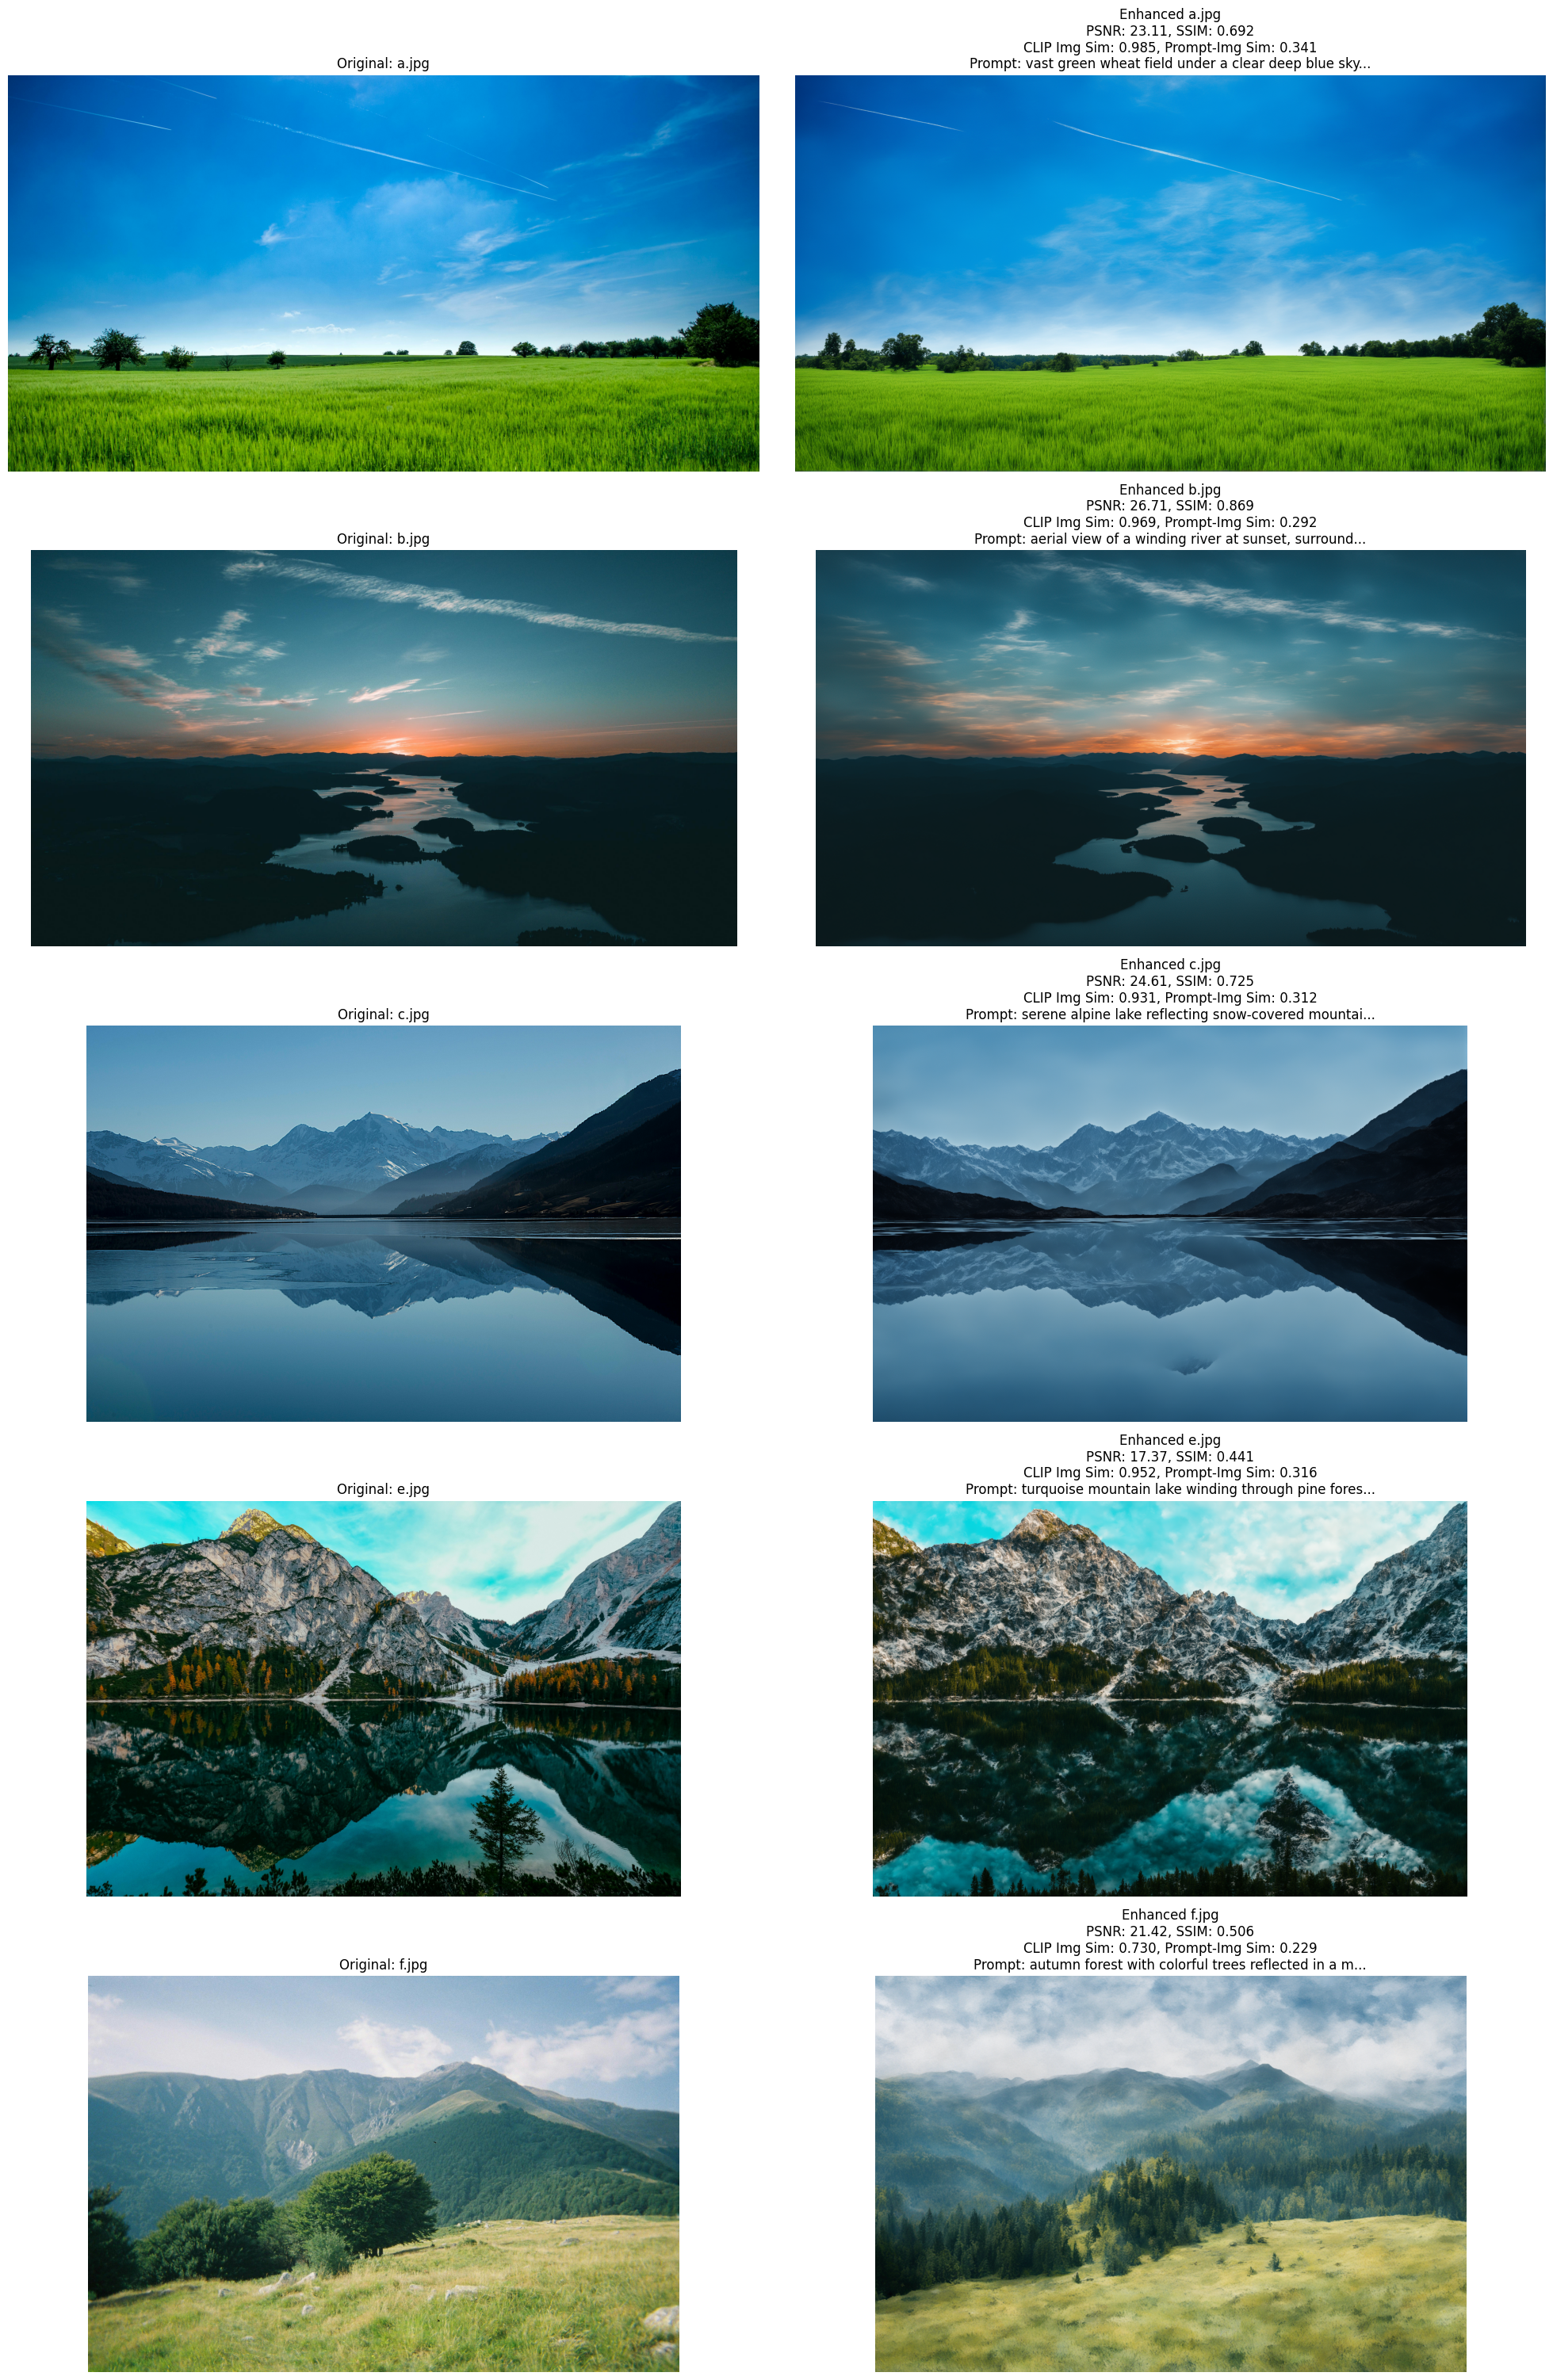

In [15]:
# Visualize landscape results
if 'sdxl_no_text' in locals() and len(sdxl_no_text) > 0:
    visualize_results(
        resized_no_text,
        sdxl_no_text,
        filenames_no_text,
        metrics_no_text,
        prompts_no_text[:len(sdxl_no_text)],
        num_images=5  # Adjust as needed
    )

## Summary of Enhanced Images

In [16]:
# Count and list enhanced images
enhanced_files = [f for f in os.listdir(output_dir) if f.startswith('enhanced_')]
print(f"Total enhanced landscape images saved: {len(enhanced_files)}")
print(f"Output directory: {os.path.abspath(output_dir)}")

if enhanced_files:
    print("\nSample of enhanced images:")
    for file in enhanced_files[:5]:  # Show first 5
        print(f"- {file}")
    if len(enhanced_files) > 5:
        print(f"...and {len(enhanced_files) - 5} more")

Total enhanced landscape images saved: 10
Output directory: /content/drive/MyDrive/sdxl_output_no_text

Sample of enhanced images:
- enhanced_a.png
- enhanced_b.png
- enhanced_c.png
- enhanced_e.png
- enhanced_f.png
...and 5 more
